# Currency exchange rate trends analyzer

### Trend analysis for EURPLN exchange rates using data from 2013.09.09 to 2016.09.05 time period

In [371]:
# customarilily import most important libraries

import pandas as pd                       # pandas is a dataframe library
import matplotlib.pyplot as plt           # matplotlib.pyplot plots data
import numpy as np                        # numpy provides N-dim object support

import matplotlib.dates as mdates         


# do ploting inline instead of in a separate window
%matplotlib inline

In [372]:
df = pd.read_csv('./data-archive/EUR_2013.09.09_2016.09.05.csv', sep=';')     # load data

In [373]:
# get brief statistics over data we just read
df_columns, df_rows = df.shape

print("File contains {} rows and {} columns of data.".format(df_columns, df_rows))

File contains 755 rows and 4 columns of data.


#### Show first 3 rows from file

In [374]:
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
0,2016-09-05,4.3480,-0.72,171/A/NBP/2016
1,2016-09-02,4.3796,0.43,170/A/NBP/2016
2,2016-09-01,4.3607,0.12,169/A/NBP/2016


#### Show last 3 rows from file

In [375]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
752,2013-09-11,4.2408,-0.54,176/A/NBP/2013
753,2013-09-10,4.2637,-0.15,175/A/NBP/2013
754,2013-09-09,4.2700,-0.64,174/A/NBP/2013


As we can see, data are not ordered chronologically. We must reverse the order of rows so that first row is the oldest, last row is the newest.

In [376]:
df = df.sort_index(axis=0, ascending=True)
df = df.iloc[::-1]
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
754,2013-09-09,4.2700,-0.64,174/A/NBP/2013
753,2013-09-10,4.2637,-0.15,175/A/NBP/2013
752,2013-09-11,4.2408,-0.54,176/A/NBP/2013


In [377]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
2,2016-09-01,4.3607,0.12,169/A/NBP/2016
1,2016-09-02,4.3796,0.43,170/A/NBP/2016
0,2016-09-05,4.3480,-0.72,171/A/NBP/2016


Data frame (rows) is reversed now, which we can prove by observing values on the diagram

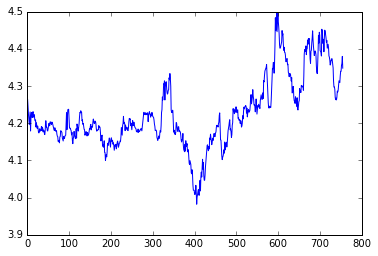

In [378]:
plt.plot(df['Kurs'].values)

### SMA - simple moving average

In [379]:
# an example on how to calculate SMA for a collection of data
v = {'score': [1, 2, 2, 3, 3, 4]}
data_frame = pd.DataFrame(v)
pd.rolling_mean(data_frame, 2)

,score
0,NaN
1,1.5
2,2.0
3,2.5
4,3.0
5,3.5


#### Calculate various SMA 

In order to perform better analysis, we will use recent data

In [380]:
# get last 100 exchange rates
last_days_to_analyze = 300
last_days_to_observe = 200

recent_exchange_rates = exchange_rates[-last_days_to_analyze:]
recent_dates = df['Kurs'].values[-last_days_to_analyze:]

In [381]:
# create new DataFrame containing exchange rates ordered chronologically (oldest first, newest last)
df_exchange_rates = pd.DataFrame(recent_exchange_rates)

# calculate most common SMA (for short-term traders)
df_sma_10 = pd.rolling_mean(df_exchange_rates, 10)
df_sma_20 = pd.rolling_mean(df_exchange_rates, 20)
df_sma_50 = pd.rolling_mean(df_exchange_rates, 50)

In [382]:
# get data for last days we are interested in
recent_exchange_rates = recent_exchange_rates[-last_days_to_observe:]
sma_10 = df_sma_10[-last_days_to_observe:].values
sma_20 = df_sma_20[-last_days_to_observe:].values
sma_50 = df_sma_50[-last_days_to_observe:].values

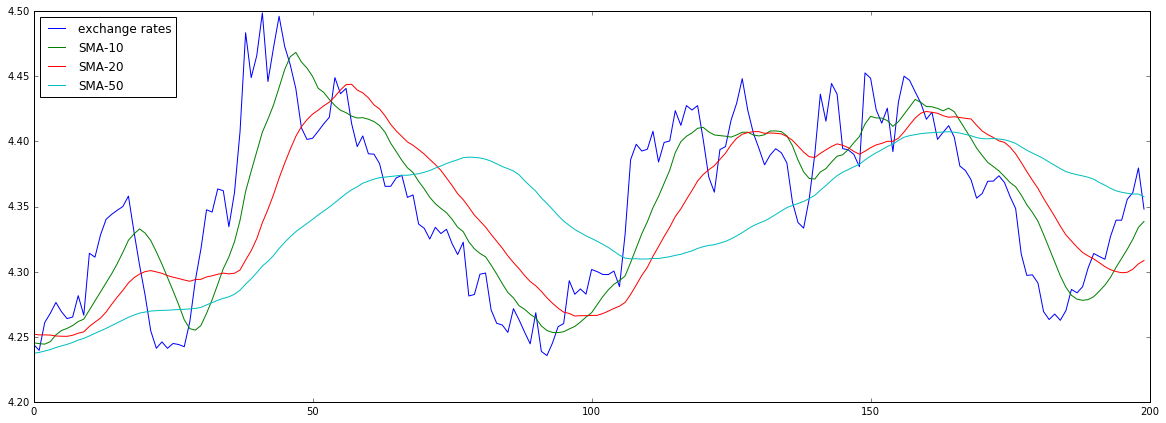

In [383]:
plt.figure(figsize=(20,7))

plt.plot(recent_exchange_rates)
plt.plot(sma_10)
plt.plot(sma_20)
plt.plot(sma_50)

plt.legend(['exchange rates', 'SMA-10', 'SMA-20', 'SMA-50'], loc='upper left')